In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import graph_tool as gt
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
from graph_tool.topology import shortest_distance, shortest_path
import matplotlib as mpl
import matplotlib.cm as cm

In [2]:
%config Completer.use_jedi = False

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [17]:
def merge2network(new_nodes, streets, node_type="source"):

   nodes, edges = ox.graph_to_gdfs(streets)

   nodes_ = nodes[~nodes.osmid.isna()]

   stop_index = nodes.index.min()

   start_index = stop_index-len(new_nodes)

   indices = range(start_index, stop_index)

   new_nodes.index = indices

   new_nodes['nearest_length'], new_nodes['nearest_id'] = \
    zip(*new_nodes[['y', 'x']].apply(lambda x: nearest_neighbor(nodes_[['y', 'x']], x, nodes_), axis=1))


   node_cols = ['x', 'y', 'geometry']

   n = nodes.append(new_nodes[node_cols])

   n.gdf_name = nodes.gdf_name

   if node_type=="source":

       e = edges.append(draw_edges(new_nodes.index, new_nodes['nearest_id'].astype(int), new_nodes['nearest_length'], nodes, new_nodes))
   elif node_type=="sink":

       e = edges.append(draw_edges(new_nodes['nearest_id'].astype(int), new_nodes.index, new_nodes['nearest_length'], nodes, new_nodes))
        
   e.reset_index(drop=True)
   return list(indices), ox.save_load.gdfs_to_graph(n, e)

In [18]:
def haversine(loc1, loc2):

   """ Calculate the great circle distance between two points on the earth (specified in decimal degrees)

   loc1: single point

   loc2: array-like

   """

   R = 6372.8 # in km

   lon1, lat1 = np.radians(loc1['x']), np.radians(loc1['y'])

   lon2, lat2 = np.radians(loc2['x'].astype('float')), np.radians(loc2['y'].astype('float'))

   # haversine formula

   dlon = lon2 - lon1

   dlat = lat2 - lat1

   a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

   c = 2 * np.arcsin(np.sqrt(a))

   km = R * c

   return km*1000

In [19]:
def nearest_neighbor(points, coord, nodes):

    distances = haversine(coord, points)

#     distances = np.sqrt((coord['y']-points['y'])**2 + (coord['x']-points['x'])**2)

    location = np.where(distances==np.min(distances))[0][0]

    return np.min(distances), nodes.iloc[location].name

In [20]:
def draw_edges(u,v, length, nodes, buildings):

    new_edges = pd.DataFrame([], columns=['u', 'v'])

    new_edges['u'] = u.values

    new_edges['v'] = v.values

    new_edges['length'] = length.values

    new_edges['geometry'] = buildings.apply(lambda x: 

                                            LineString([x.geometry.centroid, nodes.loc[x.nearest_id].geometry]),

                                            axis=1).values

    return new_edges

In [35]:
san_francisco_sorted = pd.read_csv('sf_stations_2017.csv')

In [36]:
san_francisco_sorted.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,origin_latlong,destination_latlong
0,715,2017-08-05 16:08:00.6140,2017-08-05 16:19:56.0110,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,40,Laguna St at McAllister St,37.779208,-122.426829,383,Subscriber,1981.0,Male,POINT (-122.4049043655396 37.78637526861584),POINT (-122.4268287 37.77920820000001)
1,6424,2017-07-03 17:52:40.8100,2017-07-03 19:39:45.1660,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6,The Embarcadero at Sansome St,37.804770,-122.403234,62,Customer,NaN,NaN,POINT (-122.4049043655396 37.78637526861584),POINT (-122.403234 37.80477)
2,4260,2017-09-22 12:53:05.8910,2017-09-22 14:04:06.7640,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6,The Embarcadero at Sansome St,37.804770,-122.403234,1971,Customer,NaN,NaN,POINT (-122.4049043655396 37.78637526861584),POINT (-122.403234 37.80477)
3,17233,2017-08-04 01:40:27.5610,2017-08-04 06:27:40.8100,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,40,Laguna St at McAllister St,37.779208,-122.426829,2230,Customer,NaN,NaN,POINT (-122.4049043655396 37.78637526861584),POINT (-122.4268287 37.77920820000001)
4,632,2017-10-21 14:13:32.2390,2017-10-21 14:24:04.9410,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,75,Market St at Franklin St,37.773793,-122.421239,1660,Subscriber,1996.0,Male,POINT (-122.4049043655396 37.78637526861584),POINT (-122.4212390184402 37.77379320608871)


In [37]:
san_francisco_sorted = san_francisco_sorted.drop(['origin_latlong', 'destination_latlong'], axis=1)
san_francisco_sorted.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,715,2017-08-05 16:08:00.6140,2017-08-05 16:19:56.0110,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,40,Laguna St at McAllister St,37.779208,-122.426829,383,Subscriber,1981.0,Male
1,6424,2017-07-03 17:52:40.8100,2017-07-03 19:39:45.1660,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6,The Embarcadero at Sansome St,37.804770,-122.403234,62,Customer,NaN,NaN
2,4260,2017-09-22 12:53:05.8910,2017-09-22 14:04:06.7640,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6,The Embarcadero at Sansome St,37.804770,-122.403234,1971,Customer,NaN,NaN
3,17233,2017-08-04 01:40:27.5610,2017-08-04 06:27:40.8100,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,40,Laguna St at McAllister St,37.779208,-122.426829,2230,Customer,NaN,NaN
4,632,2017-10-21 14:13:32.2390,2017-10-21 14:24:04.9410,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,75,Market St at Franklin St,37.773793,-122.421239,1660,Subscriber,1996.0,Male


In [38]:
origin_latlong = [Point(xy) for xy in zip(san_francisco_sorted.start_station_longitude, san_francisco_sorted.start_station_latitude)]
destination_latlong = [Point(xy) for xy in zip(san_francisco_sorted.end_station_longitude, san_francisco_sorted.end_station_latitude)]

In [39]:
sf_sorted_gdf = gpd.GeoDataFrame(san_francisco_sorted, crs = {'init': 'epsg:4326'}, geometry= origin_latlong)

In [40]:
sf_sorted_gdf = sf_sorted_gdf.rename(columns={'geometry':'origin_latlong'}).set_geometry('origin_latlong')

In [41]:
sf_sorted_gdf = gpd.GeoDataFrame(sf_sorted_gdf, crs = {'init': 'epsg:4326'}, geometry= destination_latlong)

In [42]:
sf_sorted_gdf = sf_sorted_gdf.rename(columns={'geometry':'destination_latlong'}).set_geometry('destination_latlong')

In [43]:
sf_sorted_gdf.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,origin_latlong,destination_latlong
0,715,2017-08-05 16:08:00.6140,2017-08-05 16:19:56.0110,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,40,Laguna St at McAllister St,37.779208,-122.426829,383,Subscriber,1981.0,Male,POINT (-122.4049043655396 37.78637526861584),POINT (-122.4268287 37.77920820000001)
1,6424,2017-07-03 17:52:40.8100,2017-07-03 19:39:45.1660,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6,The Embarcadero at Sansome St,37.804770,-122.403234,62,Customer,NaN,NaN,POINT (-122.4049043655396 37.78637526861584),POINT (-122.403234 37.80477)
2,4260,2017-09-22 12:53:05.8910,2017-09-22 14:04:06.7640,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6,The Embarcadero at Sansome St,37.804770,-122.403234,1971,Customer,NaN,NaN,POINT (-122.4049043655396 37.78637526861584),POINT (-122.403234 37.80477)
3,17233,2017-08-04 01:40:27.5610,2017-08-04 06:27:40.8100,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,40,Laguna St at McAllister St,37.779208,-122.426829,2230,Customer,NaN,NaN,POINT (-122.4049043655396 37.78637526861584),POINT (-122.4268287 37.77920820000001)
4,632,2017-10-21 14:13:32.2390,2017-10-21 14:24:04.9410,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,75,Market St at Franklin St,37.773793,-122.421239,1660,Subscriber,1996.0,Male,POINT (-122.4049043655396 37.78637526861584),POINT (-122.4212390184402 37.77379320608871)


In [44]:
bike_lanes = ox.load_graphml('bike_lanes.graphml', folder='./')

In [45]:
origin = gpd.GeoDataFrame(sf_sorted_gdf.origin_latlong, crs={'init': 'epsg:4326'}, geometry='origin_latlong')
destination = gpd.GeoDataFrame(sf_sorted_gdf.destination_latlong, crs={'init': 'epsg:4326'}, geometry='destination_latlong')

In [46]:
columns = ["geometry", "x","y"]

origin["geometry"] = origin.geometry.centroid
origin["x"] = origin.geometry.x
origin["y"] = origin.geometry.y

destination["geometry"] = destination.geometry.centroid
destination["x"] = destination.geometry.x
destination["y"] = destination.geometry.y

In [47]:
nodes, edges = ox.graph_to_gdfs(bike_lanes)

In [48]:
source_node_indices, bike_lanes_merged = merge2network(origin[columns].head(100), bike_lanes, node_type="source")
sink_node_indices, bike_lanes_merged = merge2network(destination[columns].head(100), bike_lanes_merged, node_type="sink")

NameError: name 'merge2network' is not defined

In [ ]:
#ox.save_load.save_graphml(bike_lanes_merged, "sf_2017_merged.graphml", folder="./")

In [ ]:
nodes, edges = ox.graph_to_gdfs(bike_lanes_merged)

nodes["iloc"] = range(nodes.shape[0])

sources = {nodes.loc[i]["iloc"]: i for i in source_node_indices}

sinks = {nodes.loc[i]["iloc"]: i for i in sink_node_indices}

In [ ]:
graph = gt.load_graph("sf_2017_merged.graphml")
length = graph.new_edge_property("float")

In [ ]:
for e in graph.edges():
    length[e] = float(graph.ep["length"][e])

In [ ]:
source_keys = list(sources.keys())
sink_keys = list(sinks.keys())

arr = [shortest_path(graph, graph.vertex(source_keys[i]), graph.vertex(sink_keys[i]), \
                                  weights=length) for i in range(len(source_keys))]

In [ ]:
arr[0][1][1]

In [49]:
osm_source_nodes = ox.get_nearest_nodes(bike_lanes)

TypeError: get_nearest_nodes() missing 2 required positional arguments: 'X' and 'Y'

In [50]:
osm_source_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        sf_sorted_gdf.start_station_longitude, sf_sorted_gdf.start_station_latitude, method = 'balltree')

In [51]:
osm_sink_nodes = ox.get_nearest_nodes(bike_lanes, \
                                     sf_sorted_gdf.end_station_longitude, sf_sorted_gdf.end_station_latitude, method = 'balltree')

In [52]:
osm_source_nodes

array([6250503338, 6250503338, 6250503338, ..., 5429900141, 5429900141,
       5429900141])

In [53]:
route = nx.shortest_path(bike_lanes, osm_source_nodes[0], osm_sink_nodes[0])

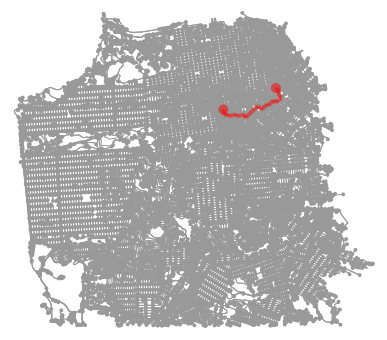

(<Figure size 624.876x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cbb54e160>)

In [54]:
ox.plot_graph_route(bike_lanes, route)

In [55]:
shortest_path_lengths = \
np.array([nx.shortest_path_length(bike_lanes, \
                                  osm_source_nodes[i], osm_sink_nodes[i], weight='length') for i in range(50)])

In [56]:
shortest_path_lengths

array([2549.873, 2871.62 , 2871.62 , 2549.873, 2382.3  , 3871.633,
       2382.3  , 3871.633, 2292.571, 3871.633, 2207.341, 1442.278,
       2871.62 , 1926.314, 4608.211, 1300.676, 2210.536, 1926.314,
       1631.348, 2426.571, 2871.62 , 1300.676, 2042.183, 1608.024,
       2207.341, 2007.73 , 2871.62 , 1934.502, 2138.158, 1442.278,
       2650.381,  862.462, 2042.183, 1666.671, 1527.544, 2426.571,
       3790.016, 1300.676, 1300.676, 1442.278, 1300.676, 2264.968,
       1442.278, 1862.543, 2264.968, 2264.968, 1442.278, 1905.041,
       1731.116, 1905.041])

In [57]:
unique_trips = san_francisco_sorted.drop_duplicates(subset=['start_station_id', 'end_station_id'])
len(unique_trips)

15114

In [58]:
unique_sources = ox.get_nearest_nodes(bike_lanes, \
                                        unique_trips.start_station_longitude, unique_trips.start_station_latitude, method = 'balltree')

In [59]:
unique_sinks = ox.get_nearest_nodes(bike_lanes, \
                                        unique_trips.end_station_longitude, unique_trips.end_station_latitude, method = 'balltree')

In [60]:
unique_path_lengths = np.array([nx.shortest_path_length\
                                (bike_lanes, unique_sources[i], \
                                 unique_sinks[i], weight = 'length') for i in range(len(unique_sources))])

In [61]:
unique_path_lengths

array([2549.873, 2871.62 , 2382.3  , ...,    0.   ,   32.392,    0.   ])

In [62]:
unique_trips['path_length'] = unique_path_lengths

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
san_francisco_sorted.groupby(by=['start_station_id', 'end_station_id']).mean

<bound method GroupBy.mean of <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x7f9d0cdc2940>>

In [64]:
unique_trips.groupby(by=['start_station_id', 'end_station_id']).mean()

duration_sec  start_station_latitude  \
start_station_id end_station_id                                         
3                3                       1823               37.786375   
                 4                        220               37.786375   
                 5                        492               37.786375   
                 6                       6424               37.786375   
                 8                       1099               37.786375   
                 9                       1404               37.786375   
                 10                      1297               37.786375   
                 11                       498               37.786375   
                 13                      3233               37.786375   
                 14                       727               37.786375   
                 15                      1579               37.786375   
                 16                       359               37.786375   
                 17                       284               37.786375   
                 19                      7584               37.786375   
                 20                       301               37.786375   
                 21                       602               37.786375   
                 22                       363               37.786375   
                 23                      1120               37.786375   
                 24                       446               37.786375   
                 25                       220               37.786375   
                 26                       401               37.786375   
                 27                       740               37.786375   
                 28                       696               37.786375   
                 29                      1164               37.786375   
                 30                       426               37.786375   
                 31                      1487               37.786375   
                 33                       680               37.786375   
                 34                       444               37.786375   
                 36                       353               37.786375   
                 37                       427               37.786375   
...                                       ...                     ...   
337              200                      704               37.806970   
                 202                      544               37.806970   
                 232                     2545               37.806970   
                 233                      583               37.806970   
                 337                      938               37.806970   
                 338                      212               37.806970   
338              7                        604               37.803189   
                 162                      208               37.803189   
                 163                      356               37.803189   
                 181                      387               37.803189   
                 182                      285               37.803189   
                 183                      291               37.803189   
                 186                      369               37.803189   
                 195                     1240               37.803189   
                 196                      430               37.803189   
                 197                      998               37.803189   
                 198                      238               37.803189   
                 200                      428               37.803189   
                 202                      834               37.803189   
                 211                      998               37.803189   
                 213                      806               37.803189   
                 221                     1325               37.803189   
                 2

In [65]:
unique_path = np.array([nx.shortest_path(bike_lanes, unique_sources[i], unique_sinks[i], weight='length') for i in range(len(unique_sources))])

In [66]:
#unique_path = nx.shortest_paths

In [67]:
bike_lanes.node[unique_sources[0]]

{'y': 37.7863266, 'x': -122.4050164, 'osmid': 6250503338}

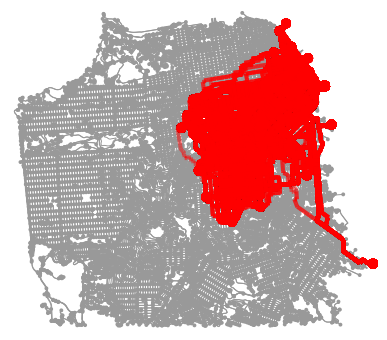

(<Figure size 624.876x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cb27b0d30>)

In [68]:
ox.plot_graph_routes(bike_lanes, unique_path)

In [69]:
bike_lanes.get_edge_data(unique_path[0][0], unique_path[0][1])

{0: {'osmid': 25284933,
  'name': 'Yerba Buena Lane',
  'highway': 'pedestrian',
  'oneway': False,
  'length': 187.874,
  'geometry': <shapely.geometry.linestring.LineString at 0x7f9cc5f76cf8>}}

In [70]:
od_pairs = unique_trips[['start_station_id', 'end_station_id', 'path_length']]

In [71]:
od_pairs['node_route'] = unique_path

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
len(unique_path[0])

40

In [73]:
od_pairs.to_csv('od_pair_paths.csv',index=False)

In [74]:
od_pairs.head()

,start_station_id,end_station_id,path_length,node_route
0,3,40,2549.873,"[6250503338, 275431510, 65351772, 371151373, 5..."
1,3,6,2871.620,"[6250503338, 275431510, 65351772, 1270745636, ..."
4,3,75,2382.300,"[6250503338, 275431510, 65351772, 371151373, 5..."
5,3,52,3871.633,"[6250503338, 275431510, 65351772, 371151373, 5..."
8,3,93,2292.571,"[6250503338, 275431510, 65351772, 65319526, 65..."


In [75]:
len(od_pairs)

15114

In [76]:
regular_trips = pd.read_csv('regular_trips.csv', usecols=[1,2,3,4])
regular_trips.head()

,start_station_id,end_station_id,avg_duration,counts
0,15,6,23.572877,3344
1,6,16,10.852045,1793
2,6,15,16.707699,1734
3,81,15,13.149140,1686
4,48,21,6.143870,1509


In [77]:
len(regular_trips)

18392

In [78]:
trip_data = pd.merge(regular_trips, od_pairs, how='inner', on=['start_station_id', 'end_station_id'])

In [79]:
trip_data.head()

,start_station_id,end_station_id,avg_duration,counts,path_length,node_route
0,15,6,23.572877,3344,1390.701,"[6319310906, 302728575, 6319310920, 6319310900..."
1,6,16,10.852045,1793,1447.884,"[33241803, 260194262, 280836272, 6250503702, 2..."
2,6,15,16.707699,1734,1388.261,"[33241803, 260194262, 6319307883, 612028717, 6..."
3,81,15,13.149140,1686,2576.205,"[65351790, 260193155, 260193156, 6311883025, 2..."
4,48,21,6.143870,1509,1190.917,"[65317054, 65299058, 65317051, 65317050, 65290..."


In [80]:
od_pairs[od_pairs['start_station_id']==15].head()

,start_station_id,end_station_id,path_length,node_route
58816,15,6,1390.701,"[6319310906, 302728575, 6319310920, 6319310900..."
58817,15,81,2593.339,"[6319310906, 6319310910, 1108824627, 293626968..."
58818,15,58,3134.148,"[6319310906, 6319310910, 1108824627, 293626968..."
58821,15,25,2887.868,"[6319310906, 6319310910, 1108824627, 293626968..."
58824,15,5,1960.891,"[6319310906, 6319310910, 1108824627, 293626968..."


In [81]:
trip_data.avg_duration = trip_data.avg_duration / 60.0

In [82]:
trip_data.path_length = trip_data.path_length / 1000.0

In [83]:
trip_data['velocity'] = trip_data.path_length / trip_data.avg_duration

In [84]:
trip_data.head()

,start_station_id,end_station_id,avg_duration,counts,path_length,node_route,velocity
0,15,6,0.392881,3344,1.390701,"[6319310906, 302728575, 6319310920, 6319310900...",3.539749
1,6,16,0.180867,1793,1.447884,"[33241803, 260194262, 280836272, 6250503702, 2...",8.005223
2,6,15,0.278462,1734,1.388261,"[33241803, 260194262, 6319307883, 612028717, 6...",4.985466
3,81,15,0.219152,1686,2.576205,"[65351790, 260193155, 260193156, 6311883025, 2...",11.755316
4,48,21,0.102398,1509,1.190917,"[65317054, 65299058, 65317051, 65317050, 65290...",11.630295


(-1, 35)

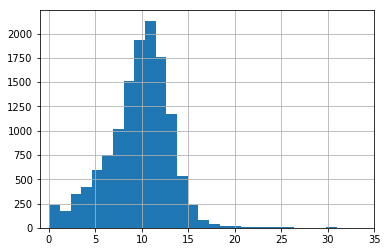

In [85]:
trip_data[trip_data.velocity!=0].velocity.hist(bins=50).set_xlim(-1, 35)

In [86]:
nodes, edges = ox.save_load.graph_to_gdfs(bike_lanes)

In [87]:
edges.head()

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,"LINESTRING (-122.4592947 37.7472475, -122.4593...",tertiary,NaN,0,NaN,12.542,35 mph,Dewey Boulevard,True,133743841,NaN,NaN,NaN,287834139,1472038598,NaN
1,NaN,NaN,"LINESTRING (-122.4592947 37.7472475, -122.4592...",secondary,NaN,0,2,8.340,NaN,Laguna Honda Boulevard,True,133743862,NaN,NaN,NaN,287834139,1472038599,NaN
2,NaN,NaN,"LINESTRING (-122.4637661 37.7736374, -122.4636...",secondary,NaN,0,4,94.392,35 mph,Fulton Street,False,162799061,NaN,NaN,NaN,4022927416,4022924671,NaN
3,NaN,NaN,"LINESTRING (-122.4637661 37.7736374, -122.4638...",residential,NaN,0,2,193.092,NaN,6th Avenue,False,199319891,NaN,NaN,NaN,4022927416,65302782,NaN
4,NaN,NaN,"LINESTRING (-122.4637661 37.7736374, -122.4639...",secondary,NaN,0,4,94.744,35 mph,Fulton Street,False,619378851,NaN,NaN,NaN,4022927416,4022924680,NaN


In [88]:
trip_data.head()

,start_station_id,end_station_id,avg_duration,counts,path_length,node_route,velocity
0,15,6,0.392881,3344,1.390701,"[6319310906, 302728575, 6319310920, 6319310900...",3.539749
1,6,16,0.180867,1793,1.447884,"[33241803, 260194262, 280836272, 6250503702, 2...",8.005223
2,6,15,0.278462,1734,1.388261,"[33241803, 260194262, 6319307883, 612028717, 6...",4.985466
3,81,15,0.219152,1686,2.576205,"[65351790, 260193155, 260193156, 6311883025, 2...",11.755316
4,48,21,0.102398,1509,1.190917,"[65317054, 65299058, 65317051, 65317050, 65290...",11.630295


In [89]:
source_target_nodes = pd.DataFrame(columns=['source', 'target', 'trip_counts'])

In [90]:
raw_nodes = trip_data.node_route.values

In [91]:
node_pairs = []

In [92]:
for node in raw_nodes:
    for i in range(len(node) - 1):
        node_pairs.append([node[i], node[i+1]])

In [93]:
weights = []
count_weights = trip_data.counts.values

In [94]:
for i in range(len(trip_data)):
    for k in range(len(raw_nodes[i]) - 1):
        weights.append(count_weights[i])

In [95]:
node_pairs = np.array(node_pairs)
weights = np.array(weights)

In [96]:
source_target_nodes.source = node_pairs[:, 0]
source_target_nodes.target = node_pairs[:, 1]
source_target_nodes.trip_counts = weights

In [97]:
edge_number = []
for lis in raw_nodes:
    edge_number.append(len(lis) - 1)

In [98]:
edge_number = np.array(edge_number)

In [99]:
np.mean(edge_number)

37.917865362485614

(array([1062.,  136.,  223.,  384.,  449.,  520.,  559.,  624.,  670.,
         694.,  865.,  726.,  611.,  436.,  640.,  586.,  559.,  483.,
         502.,  443.,  397.,  368.,  351.,  284.,  300.,  242.,  105.,
         161.,  129.,  111.,   86.,   65.,   53.,   26.,   21.,   15.,
          10.,    3.,    3.,    2.]),
 array([  0.   ,   2.925,   5.85 ,   8.775,  11.7  ,  14.625,  17.55 ,
         20.475,  23.4  ,  26.325,  29.25 ,  32.175,  35.1  ,  38.025,
         40.95 ,  43.875,  46.8  ,  49.725,  52.65 ,  55.575,  58.5  ,
         61.425,  64.35 ,  67.275,  70.2  ,  73.125,  76.05 ,  78.975,
         81.9  ,  84.825,  87.75 ,  90.675,  93.6  ,  96.525,  99.45 ,
        102.375, 105.3  , 108.225, 111.15 , 114.075, 117.   ]),
 <a list of 40 Patch objects>)

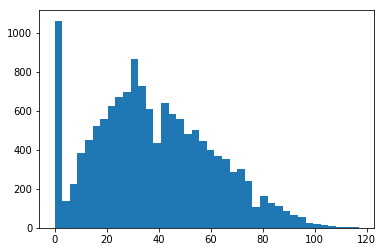

In [100]:
plt.hist(edge_number, bins=40)

In [101]:
source_target_nodes.head()

,source,target,trip_counts
0,6319310906,302728575,3344
1,302728575,6319310920,3344
2,6319310920,6319310900,3344
3,6319310900,6319310898,3344
4,6319310898,6319310894,3344


In [102]:
source_target_nodes = source_target_nodes.rename(columns={'source':'u', 'target':'v'})

In [103]:
source_target_nodes.head()

,u,v,trip_counts
0,6319310906,302728575,3344
1,302728575,6319310920,3344
2,6319310920,6319310900,3344
3,6319310900,6319310898,3344
4,6319310898,6319310894,3344


In [104]:
source_target_weights = source_target_nodes.groupby(by=['u', 'v']).sum()

In [105]:
new_edges = pd.merge(edges, source_target_weights, how='left', on=['u','v'])

In [106]:
new_edges.fillna(value=0, inplace=True)

In [107]:
new_edges[new_edges.trip_counts!=0].min()

key            0.000000e+00
length         1.129000e+00
oneway         0.000000e+00
u              3.324180e+07
v              3.324180e+07
trip_counts    1.000000e+00
dtype: float64

In [108]:
norm = mpl.colors.LogNorm(vmin=1, vmax=new_edges.trip_counts.max())
cmap = cm.YlOrRd
cmap.set_under('white')
m = cm.ScalarMappable(norm=norm, cmap=cmap)

In [109]:
new_edges['color'] = new_edges.trip_counts.apply(lambda x:m.to_rgba(x))

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:494: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


In [110]:
ec = new_edges.color.values

In [111]:
ew = [0.4 if count == 0 else 1 for count in new_edges.trip_counts.values]

In [112]:
nc = ['r' if np.sum(np.isin(node, osm_source_nodes)) == True else 'k' for node in nodes.index.values]

In [113]:
ns = [30.0 if np.sum(np.isin(node, osm_source_nodes)) == True else 0.0 for node in nodes.index.values]

In [114]:
np.isin(nodes.index.values[100], osm_source_nodes) 

array(False)

In [115]:
nodes.index.values

array([ 287834139, 4022927416,  275513407, ...,  316735478, 4784127995,
       4784127997])

In [116]:
routed_network = ox.save_load.gdfs_to_graph(nodes, new_edges)

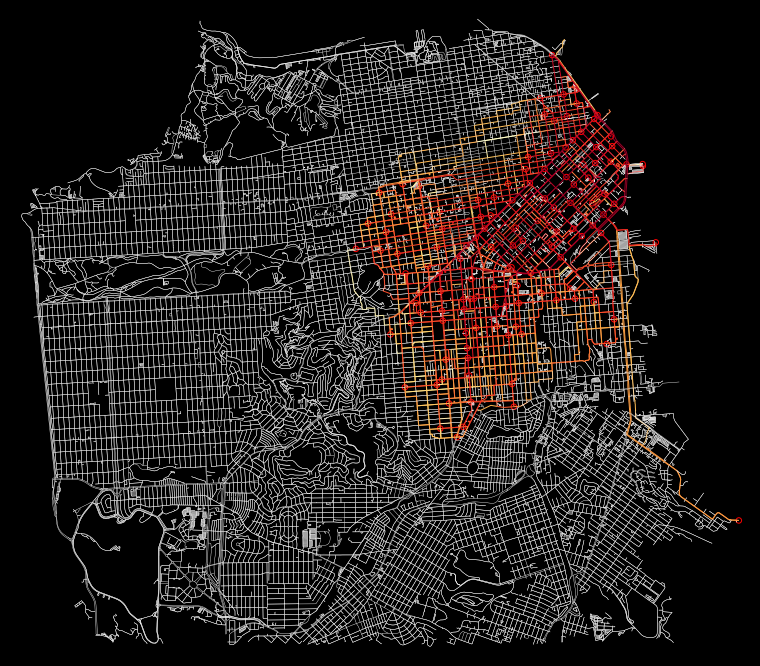

NameError: name 'make_axes_locatable' is not defined

In [117]:
fig, ax = ox.plot_graph(routed_network, node_color='k', node_edgecolor=nc, node_size=ns, edge_color=ec, fig_height=12, bgcolor='k', edge_linewidth=ew)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
l = m
l.set_array(new_edges.trip_counts.apply(lambda x:np.log10(x)).values)
fig.colorbar(l, cax=cax, orientation='vertical')
cax.set_ylabel('Number of Trips', fontsize=14, color='white')
cax.set_xlabel('')
cax.set_yticks(np.arange(0,5))
cax.set_yticklabels([r"$10^{%0.0f}$"%i for i in np.arange(0,5)], color='white')
cax.tick_params(labelsize=14, color='white')
fig

In [ ]:
ax.set_xlim(left=unique_trips.start_station_longitude.min())

In [ ]:
fig

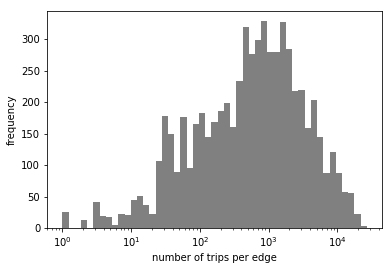

In [118]:
bins =np.geomspace(new_edges[new_edges.trip_counts!=0].trip_counts.min(),new_edges.trip_counts.max(),50)
new_edges.trip_counts.hist(bins=bins, color='gray')
plt.xscale('log')
plt.xlabel('number of trips per edge')
plt.grid(False)
plt.ylabel('frequency')
plt.savefig('edge_hist.pdf', dpi=300, bbox_inches='tight')

In [119]:
len(new_edges.trip_counts)

46524

In [138]:
10**(2.5)

316.22776601683796

In [140]:
len(np.where(new_edges.trip_counts>10000)[0]) / float(len(new_edges[new_edges.trip_counts!=0].trip_counts)) * 100

2.98956026573869

In [130]:
len(new_edges[new_edges.trip_counts!=0].trip_counts)

6322

In [134]:
len(np.where(new_edges.trip_counts>1000)[0])

2515

In [133]:
np.where(new_edges.trip_counts>1000)

(array([   16,   127,   129, ..., 46399, 46401, 46403]),)

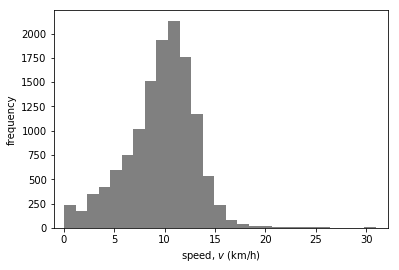

In [148]:
trip_data[trip_data.velocity!=0].velocity.hist(bins=50, color='gray')
plt.xlim(-1,32.1869)
plt.grid(False)
plt.xlabel(r"speed, $v$ (km/h)")
plt.ylabel('frequency')
plt.savefig('speed_hist.pdf', dpi=600, bbox_inches='tight')

In [149]:
len(trip_data[trip_data.velocity!=0])

13027

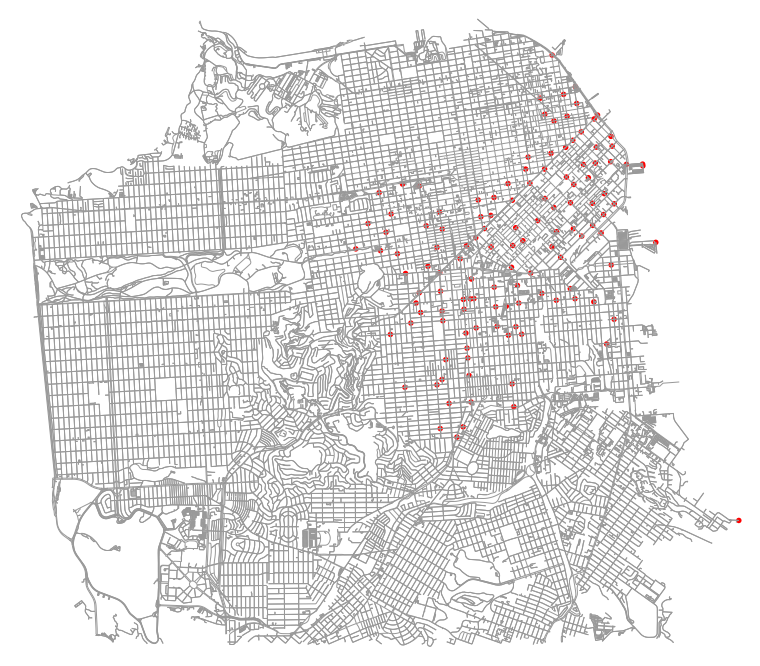

In [150]:
fig2, ax2 = ox.plot_graph(routed_network, node_color=nc, node_size=ns, fig_height=12)

In [151]:
fig2.savefig('station_loc.pdf', dpi = 600, bbox_inches = 'tight')

In [152]:
fig2.savefig('stationloc.png', dpi = 600, bbox_inches = 'tight')

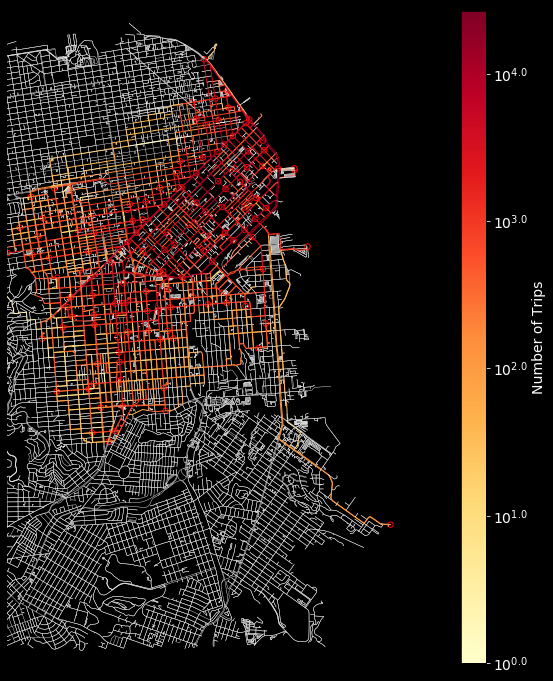

In [153]:
cax.set_ylabel('Number of Trips')
cax.set_xlabel('')
cax.set_yticks(np.arange(0,5))
cax.set_yticklabels([r"$10^{%0.1f}$"%i for i in np.arange(0,5)])
fig

In [154]:
[r"$10^{%0.1f}$"%i for i in np.arange(0,4,0.5)]

['$10^{0.0}$',
 '$10^{0.5}$',
 '$10^{1.0}$',
 '$10^{1.5}$',
 '$10^{2.0}$',
 '$10^{2.5}$',
 '$10^{3.0}$',
 '$10^{3.5}$']

In [155]:
len(san_francisco_sorted)

448112

In [156]:
len(san_francisco_sorted[san_francisco_sorted.start_station_id != san_francisco_sorted.end_station_id])

434414

In [4]:
sf_latlong = pd.read_csv('~/undergrad_thesis/ford_go_bike/sf_latlong.csv')

In [5]:
sf_latlong.head()

,Unnamed: 0,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,count
0,0,3,37.786375,-122.404904,3,37.786375,-122.404904,319
1,1,3,37.786375,-122.404904,4,37.785881,-122.408915,32
2,2,3,37.786375,-122.404904,5,37.783899,-122.408445,176
3,3,3,37.786375,-122.404904,6,37.804770,-122.403234,485
4,4,3,37.786375,-122.404904,8,37.799953,-122.398525,130


In [7]:
osm_source_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        sf_latlong.start_station_longitude, sf_latlong.start_station_latitude, method = 'balltree')

In [10]:
osm_sink_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        sf_latlong.end_station_longitude, sf_latlong.end_station_latitude, method = 'balltree')

In [11]:
path_lengths = np.array([nx.shortest_path_length\
                                (bike_lanes, osm_source_nodes[i], \
                                 osm_sink_nodes[i], weight = 'length') for i in range(len(osm_source_nodes))])

In [13]:
sf_latlong['route_distance'] = path_lengths

In [17]:
sf_latlong.head()

,Unnamed: 0,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,count,route_distance
0,0,3,37.786375,-122.404904,3,37.786375,-122.404904,319,0.000
1,1,3,37.786375,-122.404904,4,37.785881,-122.408915,32,1037.163
2,2,3,37.786375,-122.404904,5,37.783899,-122.408445,176,760.818
3,3,3,37.786375,-122.404904,6,37.804770,-122.403234,485,2871.620
4,4,3,37.786375,-122.404904,8,37.799953,-122.398525,130,2537.921


In [18]:
sf_latlong.to_csv('sf_route_distance.csv', \
                  columns=['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', \
                          'end_station_latitude', 'end_station_longitude', 'count', 'route_distance'])

In [19]:
morning_trips = pd.read_csv('~/undergrad_thesis/ford_go_bike/morning_trips.csv')
evening_trips = pd.read_csv('~/undergrad_thesis/ford_go_bike/evening_trips.csv')
afternoon_trips = pd.read_csv('~/undergrad_thesis/ford_go_bike/afternoon_trips.csv')
off_hour_trips = pd.read_csv('~/undergrad_thesis/ford_go_bike/off_hour_trips.csv')

In [20]:
morning_trips.head()

,Unnamed: 0,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,count
0,0,3,37.786375,-122.404904,3,37.786375,-122.404904,28
1,1,3,37.786375,-122.404904,4,37.785881,-122.408915,1
2,2,3,37.786375,-122.404904,5,37.783899,-122.408445,7
3,3,3,37.786375,-122.404904,6,37.804770,-122.403234,36
4,4,3,37.786375,-122.404904,8,37.799953,-122.398525,21


In [22]:
morning_source_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        morning_trips.start_station_longitude, morning_trips.start_station_latitude, method = 'balltree')
evening_source_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        evening_trips.start_station_longitude, evening_trips.start_station_latitude, method = 'balltree')
afternoon_source_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        afternoon_trips.start_station_longitude, afternoon_trips.start_station_latitude, method = 'balltree')
off_hour_source_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        off_hour_trips.start_station_longitude, off_hour_trips.start_station_latitude, method = 'balltree')

In [23]:
morning_sink_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        morning_trips.end_station_longitude, morning_trips.end_station_latitude, method = 'balltree')
evening_sink_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        evening_trips.end_station_longitude, evening_trips.end_station_latitude, method = 'balltree')
afternoon_sink_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        afternoon_trips.end_station_longitude, afternoon_trips.end_station_latitude, method = 'balltree')
off_hour_sink_nodes = ox.get_nearest_nodes(bike_lanes, \
                                        off_hour_trips.end_station_longitude, off_hour_trips.end_station_latitude, method = 'balltree')

In [25]:
morning_path_lengths = np.array([nx.shortest_path_length\
                                (bike_lanes, morning_source_nodes[i], \
                                 morning_sink_nodes[i], weight = 'length') for i in range(len(morning_source_nodes))])

In [26]:
evening_path_lengths = np.array([nx.shortest_path_length\
                                (bike_lanes, evening_source_nodes[i], \
                                 evening_sink_nodes[i], weight = 'length') for i in range(len(evening_source_nodes))])

In [27]:
afternoon_path_lengths = np.array([nx.shortest_path_length\
                                (bike_lanes, afternoon_source_nodes[i], \
                                 afternoon_sink_nodes[i], weight = 'length') for i in range(len(afternoon_source_nodes))])

In [28]:
off_hour_path_lengths = np.array([nx.shortest_path_length\
                                (bike_lanes, off_hour_source_nodes[i], \
                                 off_hour_sink_nodes[i], weight = 'length') for i in range(len(off_hour_source_nodes))])

In [32]:
morning_trips['route_distance'] = morning_path_lengths
evening_trips['route_distance'] = evening_path_lengths
afternoon_trips['route_distance'] = afternoon_path_lengths
off_hour_trips['route_distance'] = off_hour_path_lengths

In [33]:
morning_trips.to_csv('morning_route_distance.csv', \
                  columns=['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', \
                          'end_station_latitude', 'end_station_longitude', 'count', 'route_distance'])
evening_trips.to_csv('evening_route_distance.csv', \
                  columns=['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', \
                          'end_station_latitude', 'end_station_longitude', 'count', 'route_distance'])
afternoon_trips.to_csv('afternoon_route_distance.csv', \
                  columns=['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', \
                          'end_station_latitude', 'end_station_longitude', 'count', 'route_distance'])
off_hour_trips.to_csv('off_hour_route_distance.csv', \
                  columns=['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', \
                          'end_station_latitude', 'end_station_longitude', 'count', 'route_distance'])